# Notebook 031: Decision Trees using final predictor set

This notebook contains a baseline crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class Logistic Regression Models with and without regularization.

In [9]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)



%matplotlib inline

In [3]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed\X_train.csv
	../data/raw\shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [5]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [6]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [52]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [10]:
# Examine data

print(f"{len(X_train)} training samples, {len(X_test)} test samples")
print("\nColumns:")
print(', '.join(X_train.columns))

128352 training samples, 32088 test samples

Columns:
streetlights-night, lat, lon, night, tempavg, windavg, precip, snowfall, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, college-near, highschool-near, median-age, median-income, poverty-rate, less-than-high-school-perc, bachelor-degree-or-more-perc, enrolled-college-perc, commercial-mix-ratio, industrial-mix-ratio, owner-occupied-ratio, residential-median-value, residential-gini-coef, commercial-mix-ratio-3yr-cagr, industrial-mix-ratio-3yr-cagr, owner-occupied-ratio-3yr-cagr, residential-gini-coef-3yr-cagr, residential-median-value-3yr-cagr


In [ ]:
# Split into NumPy arrays
# X_train = data_train.iloc[:, data_train.columns != 'class'].values
# y_train = data_train['class'].values
# X_test = data_test.iloc[:, data_test.columns != 'class'].values
# y_test = data_test['class'].values

In [22]:
depths = list(range(1, 20))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for d in depths:
        dtree = DecisionTreeClassifier(max_depth=d)
        dtree.fit(X_train, y_train)
        
        train_score =  dtree.score(X_train, y_train)  # fit and score
              
        cvscores = cross_val_score(dtree, X_train, y_train, cv = 5)  # return list of 5 scores
        # print(cvscores)  #display cv score for each fold (for testing)
        cvmean = cvscores.mean()  # mean of scores
        cvstd = cvscores.std()  # std of scores
        
        # store appropriate values in list the function will return
        train_scores.append(train_score)
        cvmeans.append(cvmean)
        cvstds.append(cvstd)
        
    # end of your code here
    return cvmeans, cvstds, train_scores

In [23]:
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

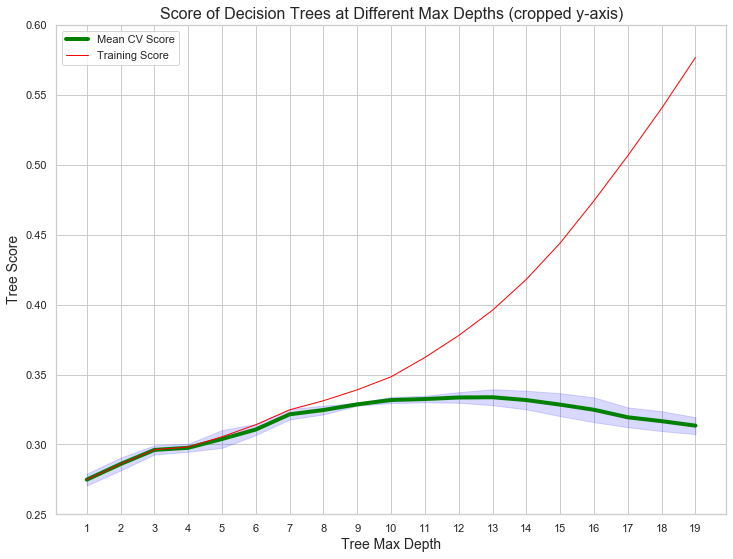

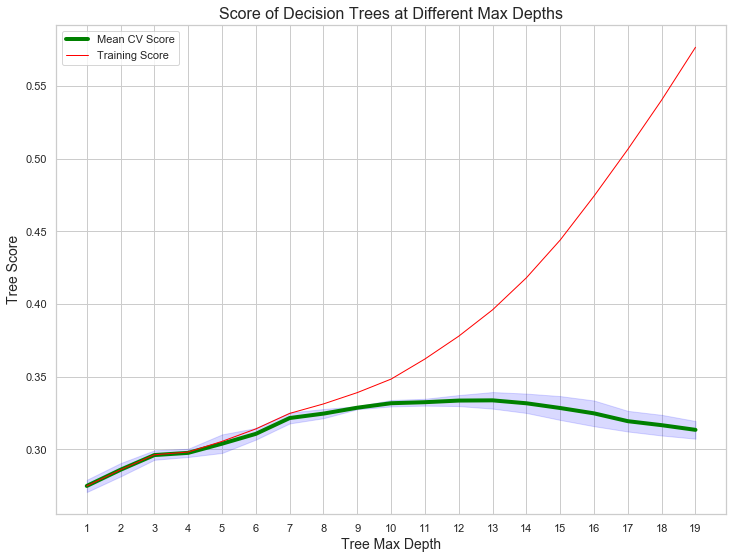

In [25]:
# add two values from a list (https://stackoverflow.com/questions/28036309)
highstd = [cvmeans[d] + 2*cvstds[d] for d in range(len(cvmeans))]
lowstd = [cvmeans[d] - 2*cvstds[d] for d in range(len(cvmeans))]


# cropped y-axis to focus only on CV scores
plt.figure(figsize=(12,9))
plt.plot(depths, cvmeans, label='Mean CV Score', linewidth=4, color='green')
plt.plot(depths, train_scores, label='Training Score', linewidth=1, color='red')
plt.fill_between(depths, highstd, lowstd, color='blue', alpha=0.15)

plt.xlabel('Tree Max Depth', fontsize=14)
plt.xticks(depths)  # by default was displaying every 2.5 so forcing line at each depth
plt.ylabel('Tree Score', fontsize=14)
plt.ylim([0.25,0.60])
plt.title('Score of Decision Trees at Different Max Depths (cropped y-axis)', fontsize=16)
plt.legend()
plt.show()


# y-axis not restricted so both curves are fully visible
plt.figure(figsize=(12,9))
plt.plot(depths, cvmeans, label='Mean CV Score', linewidth=4, color='green')
plt.plot(depths, train_scores, label='Training Score', linewidth=1, color='red')
plt.fill_between(depths, highstd, lowstd, color='blue', alpha=0.15)

plt.xlabel('Tree Max Depth', fontsize=14)
plt.xticks(depths)  # by default was displaying every 2.5 so forcing line at each depth
plt.ylabel('Tree Score', fontsize=14)
plt.title('Score of Decision Trees at Different Max Depths', fontsize=16)
plt.legend()
plt.show()

In [26]:
best_cv_tree = DecisionTreeClassifier(max_depth=5)  
best_cv_tree.fit(X_train, y_train)

best_cv_tree_train_score = best_cv_tree.score(X_train, y_train) 
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test) 

print('Accuracy of best CV tree model (Train):', best_cv_tree_train_score)
print('Accuracy of best CV tree model (Test): ', best_cv_tree_test_score)    

Accuracy of best CV tree model (Train): 0.3054880329094989
Accuracy of best CV tree model (Test):  0.30600224382946895


In [49]:
tree_depth = 30

overfit_cv_tree = DecisionTreeClassifier(max_depth=tree_depth)  
overfit_cv_tree.fit(X_train, y_train)

overfit_cv_tree_train_score = overfit_cv_tree.score(X_train, y_train) 
overfit_cv_tree_test_score = overfit_cv_tree.score(X_test, y_test) 

print('Accuracy of overfit tree model (Train):', overfit_cv_tree_train_score)
print('Accuracy of overfit tree model (Test): ', overfit_cv_tree_test_score)  

Accuracy of overfit tree model (Train): 0.887925392670157
Accuracy of overfit tree model (Test):  0.29094988780852654


In [63]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here

def bagger(n_trees: int, tree_depth: int,  random_seed=109) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    
    bagging_train_df = pd.DataFrame(y_train)
    bagging_test_df = pd.DataFrame(y_test)
    bagging_models = []
    
    for x in range(1,n_trees+1):
        #create bootstrap sample
        sample_X_train = resample(X_train, replace=True, n_samples=5000, random_state=(109))
        sample_y_train = resample(y_train, replace=True, n_samples=5000, random_state=(109))
        
        #create model
        tree_clf_temp = DecisionTreeClassifier(max_depth=tree_depth)
        tree_clf_temp = tree_clf_temp.fit(sample_X_train, sample_y_train)
        
        #make predictions
        y_test_preds_temp = tree_clf_temp.predict(X_test)
        y_train_preds_temp = tree_clf_temp.predict(X_train)

        bagging_train_df[str(x)]=y_train_preds_temp
        bagging_test_df[str(x)]=y_test_preds_temp
        bagging_models.append(tree_clf_temp)
        
        
    return bagging_train_df, bagging_test_df, bagging_models

In [64]:
n_trees = 55
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1,1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,8,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,6,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,6,3,3,6,6,3,3,3,3,3,3,3,3,3,3


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,8,0,4,4,4,4,4,4,4,0,0,4,4,0,0,0,0,4,0,0,0,0,4,4,0,0,0,8,0,0,4,0,0,0,0,8,4,0,4,0,0,0,0,0,4,4,4,4,4,0,4,4,4,0,0,4
1,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,6,0,0,3,0,3,0,0,6,0,0,3,3,3,0,0,3,0,0,3,0,3,0,3,3,0,0,0,6,0,0,0,3,0,6,6,0,0,0,0,0,0,3,0,0,3,3,3,6,0,0,0,0,3,0,0
3,0,4,2,4,2,2,4,2,2,2,2,2,2,4,2,2,2,2,2,4,4,4,2,2,4,2,2,4,2,2,2,2,2,2,2,2,2,2,2,2,4,4,2,2,2,2,4,2,4,4,4,2,2,4,2,2
4,3,4,4,4,6,4,6,4,6,6,6,6,4,6,4,4,4,6,4,4,4,6,6,6,4,4,6,4,4,6,6,6,4,4,4,4,6,6,4,6,6,4,4,4,4,4,6,6,6,4,6,4,4,4,6,6


In [65]:
# predictions on training data

# (https://www.geeksforgeeks.org/python-pandas-dataframe-mean/)
bagging_train_pred = bagging_train_df.mean(axis=1)
# display(bagging_train_pred.head(5))  # test for correct conversion

# replace means less or equal to 0.5 with 0
pred0 = bagging_train_pred <= 0.5
bagging_train_pred = bagging_train_pred.where(~pred0, other=0)

# replace means greater than 0.5 with 1
pred1 = bagging_train_pred > 0.5
bagging_train_pred = bagging_train_pred.where(~pred1, other=1)
# display(bagging_train_pred.head(5)) # test for correct conversion

# ----------------------------------------
# predictions on testing data

# (https://www.geeksforgeeks.org/python-pandas-dataframe-mean/)
bagging_test_pred = bagging_test_df.mean(axis=1)
# display(bagging_test_pred.head(5))  # test for correct conversion

# replace means less or equal to 0.5 with 0
pred0 = bagging_test_pred <= 0.5
bagging_test_pred = bagging_test_pred.where(~pred0, other=0)

# replace means greater than 0.5 with 1
pred1 = bagging_test_pred > 0.5
bagging_test_pred = bagging_test_pred.where(~pred1, other=1)
# display(bagging_test_pred.head(5))  # test for correct conversion

# ----------------------------------------
# accuracy for training and test

bagging_accuracy_train = accuracy_score(y_train, bagging_train_pred)
bagging_accuracy_test = accuracy_score(y_test, bagging_test_pred)

print('Accuracy of bagging model (Train): ', bagging_accuracy_train)
print('Accuracy of bagging Model (Test): ', bagging_accuracy_test)

Accuracy of bagging model (Train):  0.04878770880079781
Accuracy of bagging Model (Test):  0.04730740463724757


In [66]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

ValueError: x and y must have same first dimension, but have shapes (55,) and (56,)

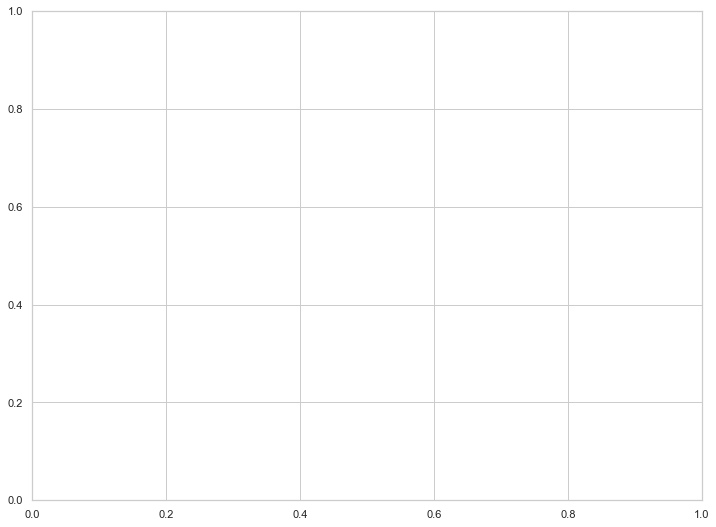

In [67]:
# convert dataframe back to numpy array (why not just return this from the bagger function)
# using values rather than to_numpy (compatible with older ver) (https://stackoverflow.com/questions/54424818)
bagging_train_array = bagging_train_df.values
bagging_test_array = bagging_test_df.values

# call running_predictions on created numpy arrays
bagging_train_predictions = running_predictions(bagging_train_array, y_train)
bagging_test_predictions = running_predictions(bagging_test_array, y_test)

# bootstrap number as a list from the range (https://stackoverflow.com/questions/18265935)
numbootstaps = list(range(1, n_trees + 1))

plt.figure(figsize=(12,9))

# plot data
plt.plot(numbootstaps, bagging_train_predictions, label='Bagging Train Score (depth=12)', linewidth=3, color='blue')
plt.plot(numbootstaps, bagging_test_predictions, label='Bagging Test Score (depth=12)', linewidth=3, color='purple')
plt.axhline(y=overfit_cv_tree_test_score, label='Overfit Tree Test Score (depth=12)', linewidth=3, color='red')
plt.axhline(y=best_cv_tree_test_score, label='Best Tree Test Score (depth=5)', linewidth=3, color='green')

# plot formatting
plt.xlabel('Number of Bootstraps Run', fontsize=14)
plt.ylabel('Accuracy Scores', fontsize=14)
plt.title('Affect of Number of Bootstraps Run on Accuracy', fontsize=16)
plt.legend()

plt.show()